# Olympics Data Analysis and Modeling

This notebook analyzes Summer Olympics data to answer three research questions:
1. How does the number of athletes a country sends relate to its medal count?
2. Does diversity in sports participation impact a country's medal tally?
3. How does athlete performance vary with age and experience in different Olympic sports?

## 1 - Setup and Imports


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import json
from typing import Dict, List, Tuple
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import optuna


# paths
PROJECT_ROOT = Path.cwd().parent  
DATA_PATH = PROJECT_ROOT / "data/processed/olympedia_org"
REPORTS_PATH = PROJECT_ROOT / "reports"
VIZ_PATH = PROJECT_ROOT / "visualizations"
# data verification
required_files = [
    'Olympic_Athlete_Bio.csv',
    'Olympic_Athlete_Event_Results.csv',
    'Olympic_Games_Medal_Tally.csv',
    'Olympic_Results.csv',
    'Olympics_Country.csv',
    'Olympics_Games.csv'
]

missing_files = []
for file in required_files:
    if not (DATA_PATH / file).exists():
        missing_files.append(file)

if missing_files:
    print("ERROR: The following required data files are missing:")
    for file in missing_files:
        print(f"- {file}")
    print("\nPlease ensure all data files are present in: data/processed/olympedia_org")
else:
    print("All required data files found!")
    print("Data directory: data/processed/olympedia_org")
    print("Visualizations will be saved to: visualizations")

All required data files found!
Data directory: data/processed/olympedia_org
Visualizations will be saved to: visualizations


## 2 - Data Processing
Loading and preprocessing data for all research questions


In [2]:
# datasets
print("Loading datasets...")
try:
    athletes_bio = pd.read_csv(DATA_PATH / "Olympic_Athlete_Bio.csv")
    event_results = pd.read_csv(DATA_PATH / "Olympic_Athlete_Event_Results.csv")
    medal_tally = pd.read_csv(DATA_PATH / "Olympic_Games_Medal_Tally.csv")
    countries = pd.read_csv(DATA_PATH / "Olympics_Country.csv")
    games = pd.read_csv(DATA_PATH / "Olympics_Games.csv")
    print("All datasets loaded successfully!")
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    raise

# 1. Process Athletes vs Medals Data
print("\nProcessing athletes vs medals data...")
athletes_count = (event_results
    .groupby(['edition', 'country_noc'])
    .agg({'athlete_id': 'nunique'})
    .reset_index()
    .rename(columns={'athlete_id': 'athlete_count'}))

athletes_medals_data = pd.merge(
    athletes_count,
    medal_tally,
    on=['edition', 'country_noc'],
    how='left'
)
athletes_medals_data[['gold', 'silver', 'bronze', 'total']] = athletes_medals_data[['gold', 'silver', 'bronze', 'total']].fillna(0)

# 2. Process Sports Diversity Data
print("Processing sports diversity data...")
sports_diversity = (event_results
    .groupby(['edition', 'country_noc'])
    .agg({
        'sport': lambda x: len(x.unique()),
        'event': 'count'
    })
    .reset_index()
    .rename(columns={
        'sport': 'unique_sports',
        'event': 'total_entries'
    }))

# calculate HHI
sports_concentration = (event_results
    .groupby(['edition', 'country_noc', 'sport'])
    .size()
    .reset_index(name='entries_per_sport'))

def calculate_hhi(group):
    total = group['entries_per_sport'].sum()
    if total == 0:
        return 0
    shares = group['entries_per_sport'] / total
    return (shares ** 2).sum()

hhi = (sports_concentration
    .groupby(['edition', 'country_noc'])
    .apply(calculate_hhi)
    .reset_index(name='sports_concentration_hhi'))

sports_diversity_data = pd.merge(
    sports_diversity,
    hhi,
    on=['edition', 'country_noc'],
    how='left'
).merge(
    medal_tally,
    on=['edition', 'country_noc'],
    how='left'
).fillna(0)

# 3. Process Age Performance Data
print("Processing age performance data...")
event_results['year'] = event_results['edition'].str.extract('(\d{4})').astype(int)

def extract_year(date_str):
    if pd.isna(date_str):
        return None
    try:
        return pd.to_datetime(date_str, format='%d %B %Y').year
    except:
        try:
            return pd.to_datetime(date_str, format='%B %Y').year
        except:
            try:
                return pd.to_datetime(date_str, format='mixed').year
            except:
                return None

age_performance_data = pd.merge(
    event_results,
    athletes_bio,
    on=['athlete_id'],
    how='left'
)

age_performance_data['birth_year'] = age_performance_data['born'].apply(extract_year)
age_performance_data['age'] = age_performance_data['year'] - age_performance_data['birth_year']

age_performance_data = age_performance_data[
    (age_performance_data['age'] >= 10) & 
    (age_performance_data['age'] <= 100)
]
age_performance_data['medal_value'] = age_performance_data['medal'].map({
    'Gold': 3, 'Silver': 2, 'Bronze': 1, None: 0
})

age_performance_data['experience'] = (age_performance_data
    .groupby('athlete_id')['year']
    .rank(method='dense') - 1)

# processing summary
print("\nProcessing Summary:")
for name, df in [
    ("Athletes vs Medals", athletes_medals_data),
    ("Sports Diversity", sports_diversity_data),
    ("Age Performance", age_performance_data)
]:
    print(f"\n{name} Dataset:")
    print(f"Shape: {df.shape}")
    print("Sample:")
    display(df.head(2))
    print("Column Names:", ", ".join(df.columns))

Loading datasets...
All datasets loaded successfully!

Processing athletes vs medals data...
Processing sports diversity data...


/var/folders/c8/_fy95_457bbfmr7mjk172l6w0000gn/T/ipykernel_2907/1631633881.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calculate_hhi)


Processing age performance data...

Processing Summary:

Athletes vs Medals Dataset:
Shape: (4224, 10)
Sample:


,edition,country_noc,athlete_count,edition_id,year,country,gold,silver,bronze,total
0,1896 Summer Olympics,AUS,2,1.0,1896.0,Australia,2.0,0.0,0.0,2.0
1,1896 Summer Olympics,AUT,3,1.0,1896.0,Austria,2.0,1.0,2.0,5.0


Column Names: edition, country_noc, athlete_count, edition_id, year, country, gold, silver, bronze, total

Sports Diversity Dataset:
Shape: (4224, 12)
Sample:


,edition,country_noc,unique_sports,total_entries,sports_concentration_hhi,edition_id,year,country,gold,silver,bronze,total
0,1896 Summer Olympics,AUS,2,7,0.510204,1.0,1896.0,Australia,2.0,0.0,0.0,2.0
1,1896 Summer Olympics,AUT,4,10,0.340000,1.0,1896.0,Austria,2.0,1.0,2.0,5.0


Column Names: edition, country_noc, unique_sports, total_entries, sports_concentration_hhi, edition_id, year, country, gold, silver, bronze, total

Age Performance Dataset:
Shape: (310768, 25)
Sample:


,edition,edition_id,country_noc_x,sport,event,result_id,athlete,athlete_id,pos,medal,...,height,weight,country,country_noc_y,description,special_notes,birth_year,age,medal_value,experience
0,1908 Summer Olympics,5,ANZ,Athletics,"100 metres, Men",56265,Ernest Hutcheon,64710,DNS,NaN,...,NaN,NaN,Australasia,ANZ,"Ernest Hutcheon was born in Toowoomba, Queensl...",Listed in Olympians Who Played First-Class Cri...,1889.0,19.0,NaN,0.0
1,1908 Summer Olympics,5,ANZ,Athletics,"400 metres, Men",56313,Henry Murray,64756,DNS,NaN,...,NaN,NaN,Australasia,ANZ,"Henry Murray, a New Zealand national, was one ...",Listed in Olympians Who Died in Motor Vehicle ...,1886.0,22.0,NaN,0.0


Column Names: edition, edition_id, country_noc_x, sport, event, result_id, athlete, athlete_id, pos, medal, isTeamSport, year, name, sex, born, height, weight, country, country_noc_y, description, special_notes, birth_year, age, medal_value, experience


## 3 - Feature Engineering
Creating and transforming features for all three research questions

In [3]:
print("Starting feature engineering...")

# 1. Engineer Athletes vs Medals Features
print("\n1. Engineering Athletes vs Medals features...")
def engineer_athletes_medals_features(df):
    data = df.copy()
    
    data['medals_per_athlete'] = data['total'] / data['athlete_count']
   
    data['year'] = data['edition'].str.extract('(\d{4})').astype(int)
   
    data = data.sort_values(['country_noc', 'year'])
    
    data['prev_medals'] = data.groupby('country_noc')['total'].shift(1)
    
    data['avg_medals_last_3'] = (data.groupby('country_noc')['total']
                               .rolling(3, min_periods=1)
                               .mean()
                               .reset_index(0, drop=True))
    
    return data.fillna(0)

# 2. Engineer Sports Diversity Features
print("\n2. Engineering Sports Diversity features...")
def engineer_sports_diversity_features(df):
    data = df.copy()
    
    data['sports_participation_ratio'] = data['unique_sports'] / data['total_entries']
    
    data['year'] = data['edition'].str.extract('(\d{4})').astype(int)
    
    data = data.sort_values(['country_noc', 'year'])
    
    data['sports_change'] = data.groupby('country_noc')['unique_sports'].diff()
    
    data['concentration_change'] = data.groupby('country_noc')['sports_concentration_hhi'].diff()
    
    data['medal_per_sport'] = data['total'] / data['unique_sports']
    
    return data.fillna(0)

# 3. Engineer Age Performance Features
print("\n3. Engineering Age Performance features...")
def engineer_age_performance_features(df):
    data = df.copy()
    
    # age groups
    data['age_group'] = pd.cut(
        data['age'],
        bins=[0, 20, 25, 30, 35, 100],
        labels=['Under 20', '20-25', '25-30', '30-35', 'Over 35']
    )
    
    data['career_duration'] = (data.groupby('athlete_id')['year']
                             .transform('max') - 
                             data.groupby('athlete_id')['year']
                             .transform('min'))
    
    peak_performance = (data.groupby('athlete_id')
                       .apply(lambda x: x.loc[x['medal_value'].idxmax()]['age']
                       if x['medal_value'].max() > 0 else None))
    data['peak_performance_age'] = data['athlete_id'].map(peak_performance)
    
    sport_metrics = (data.groupby('sport')
                    .agg({
                        'age': ['mean', 'std'],
                        'medal_value': 'mean'
                    }))
    sport_metrics.columns = ['age_sport_avg', 'age_std', 'medal_value_sport_avg']
    sport_metrics = sport_metrics.reset_index()
    data = pd.merge(data, sport_metrics, on='sport', how='left')
    data['relative_age_performance'] = (data['age'] - data['age_sport_avg']) / data['age_std']
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    data[numeric_cols] = data[numeric_cols].fillna(0)
    
    return data

# apply feature engineering to all datasets
print("\nApplying feature engineering...")
athletes_medals_features = engineer_athletes_medals_features(athletes_medals_data)
sports_diversity_features = engineer_sports_diversity_features(sports_diversity_data)
age_performance_features = engineer_age_performance_features(age_performance_data)

print("\nFeature Engineering Results:")

# athletes vs medals
print("\n1. Athletes vs Medals Features:")
print(f"Shape: {athletes_medals_features.shape}")
new_features = set(athletes_medals_features.columns) - set(athletes_medals_data.columns)
print("New Features:", ", ".join(new_features))
print("\nSample of new features:")
display(athletes_medals_features[list(new_features)].head(2))

# sports diversity
print("\n2. Sports Diversity Features:")
print(f"Shape: {sports_diversity_features.shape}")
new_features = set(sports_diversity_features.columns) - set(sports_diversity_data.columns)
print("New Features:", ", ".join(new_features))
print("\nSample of new features:")
display(sports_diversity_features[list(new_features)].head(2))

# age performance
print("\n3. Age Performance Features:")
print(f"Shape: {age_performance_features.shape}")
new_features = set(age_performance_features.columns) - set(age_performance_data.columns)
print("New Features:", ", ".join(new_features))
print("\nSample of new features:")
display(age_performance_features[list(new_features)].head(2))

Starting feature engineering...

1. Engineering Athletes vs Medals features...

2. Engineering Sports Diversity features...

3. Engineering Age Performance features...

Applying feature engineering...

Feature Engineering Results:

1. Athletes vs Medals Features:
Shape: (4224, 13)
New Features: prev_medals, medals_per_athlete, avg_medals_last_3

Sample of new features:


/var/folders/c8/_fy95_457bbfmr7mjk172l6w0000gn/T/ipykernel_2907/2038102287.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.loc[x['medal_value'].idxmax()]['age']


,prev_medals,medals_per_athlete,avg_medals_last_3
331,0.0,0.0,0.0
408,0.0,0.0,0.0



2. Sports Diversity Features:
Shape: (4224, 16)
New Features: concentration_change, medal_per_sport, sports_change, sports_participation_ratio

Sample of new features:


,concentration_change,medal_per_sport,sports_change,sports_participation_ratio
331,0.00000,0.0,0.0,0.095238
408,-0.25288,0.0,0.0,0.066667



3. Age Performance Features:
Shape: (310768, 32)
New Features: age_sport_avg, peak_performance_age, age_std, relative_age_performance, age_group, medal_value_sport_avg, career_duration

Sample of new features:


,age_sport_avg,peak_performance_age,age_std,relative_age_performance,age_group,medal_value_sport_avg,career_duration
0,25.418828,0.0,4.421037,-1.451883,Under 20,2.013538,0
1,25.418828,0.0,4.421037,-0.773309,20-25,2.013538,0


## 4 - Modeling and Training
Training and evaluating models.

In [4]:
print("Starting modeling process...")

def train_athletes_medals_model(data: pd.DataFrame) -> Dict:
    """Train models for athletes vs medals relationship"""
    print("\n1. Training Athletes vs Medals models...")
    
    feature_cols = ['athlete_count', 'medals_per_athlete']
    df_sorted = data.sort_values('year')
    train_size = int(len(df_sorted) * 0.8)
    
    # splitting the data
    X_train = df_sorted[feature_cols][:train_size]
    X_test = df_sorted[feature_cols][train_size:]
    y_train = df_sorted['total'][:train_size]
    y_test = df_sorted['total'][train_size:]
    
    # scaling the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # initializing models 
    models = {
        'linear': LinearRegression(),
        'ridge': Ridge(alpha=10.0),
        'lasso': Lasso(alpha=1.0),
        'random_forest': RandomForestRegressor(
            n_estimators=100,
            max_depth=6,
            min_samples_leaf=20,
            min_samples_split=10,
            max_features='sqrt',
            random_state=42
        ),
        'xgboost': xgb.XGBRegressor(
            max_depth=4,
            learning_rate=0.05,
            n_estimators=100,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=1,
            reg_lambda=1,
            random_state=42
        )
    }
    
    results = {}
    for name, model in models.items():
        cv_scores = cross_val_score(
            model, X_train_scaled, y_train,
            cv=TimeSeriesSplit(n_splits=5),
            scoring='r2'
        )
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        results[name] = {
            'model': model,
            'scaler': scaler,
            'mse': mean_squared_error(y_test, y_pred),
            'r2': r2_score(y_test, y_pred),
            'cv_r2_mean': cv_scores.mean(),
            'cv_r2_std': cv_scores.std()
        }
        if name in ['random_forest', 'xgboost']:
            results[name]['feature_importance'] = dict(zip(
                feature_cols,
                model.feature_importances_
            ))
            
        print(f"{name}: R² = {results[name]['r2']:.3f} (CV: {cv_scores.mean():.3f} ± {cv_scores.std():.3f})")
    
    return results

def train_sports_diversity_model(data: pd.DataFrame) -> Dict:
    """Train model for sports diversity impact"""
    print("\n2. Training Sports Diversity model...")
    feature_cols = ['unique_sports', 'sports_participation_ratio', 'sports_concentration_hhi']
    
    # spliting the data
    df_sorted = data.sort_values('year')
    train_size = int(len(df_sorted) * 0.8)
    
    X_train = df_sorted[feature_cols][:train_size]
    X_test = df_sorted[feature_cols][train_size:]
    y_train = df_sorted['total'][:train_size]
    y_test = df_sorted['total'][train_size:]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # training the model
    model = xgb.XGBRegressor(
        max_depth=4,
        learning_rate=0.05,
        n_estimators=100,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=1,
        reg_lambda=1,
        random_state=42
    )
    cv_scores = cross_val_score(
        model, X_train_scaled, y_train,
        cv=TimeSeriesSplit(n_splits=5),
        scoring='r2'
    )
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    results = {
        'model': model,
        'scaler': scaler,
        'mse': mean_squared_error(y_test, y_pred),
        'r2': r2_score(y_test, y_pred),
        'cv_r2_mean': cv_scores.mean(),
        'cv_r2_std': cv_scores.std(),
        'feature_importance': dict(zip(
            feature_cols,
            model.feature_importances_
        ))
    }
    
    print(f"Model R² = {results['r2']:.3f} (CV: {cv_scores.mean():.3f} ± {cv_scores.std():.3f})")
    return results

def train_age_performance_model(data: pd.DataFrame) -> Dict:
    """Train models for age-performance relationship"""
    print("\n3. Training Age Performance models...")
    
    MIN_SAMPLES = 100
    exclude_cols = ['medal_value', 'edition', 'country_noc', 'country', 'year', 'sport', 'age_group']
    feature_cols = data.select_dtypes(include=[np.number]).columns.difference(exclude_cols)
    
    sport_models = {}
    for sport in data['sport'].unique():
        try:
            sport_data = data[data['sport'] == sport]
            
            if len(sport_data) < MIN_SAMPLES:
                continue
        
            df_sorted = sport_data.sort_values('year')
            train_size = int(len(df_sorted) * 0.8)
            
            X_train = df_sorted[feature_cols][:train_size]
            X_test = df_sorted[feature_cols][train_size:]
            y_train = df_sorted['medal_value'][:train_size]
            y_test = df_sorted['medal_value'][train_size:]
            
            if len(X_test) < 10:
                continue
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # training the model
            model = xgb.XGBRegressor(
                max_depth=4,
                learning_rate=0.05,
                n_estimators=100,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_alpha=1,
                reg_lambda=1,
                random_state=42
            )
            cv_scores = cross_val_score(
                model, X_train_scaled, y_train,
                cv=min(5, len(X_train) // 20),
                scoring='r2'
            )
            
            if cv_scores.mean() <= 0:
                continue
            
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            r2 = r2_score(y_test, y_pred)
            
            if 0 < r2 < 0.95:
                sport_models[sport] = {
                    'model': model,
                    'scaler': scaler,
                    'mse': mean_squared_error(y_test, y_pred),
                    'r2': r2,
                    'cv_r2_mean': cv_scores.mean(),
                    'cv_r2_std': cv_scores.std(),
                    'feature_importance': dict(zip(
                        feature_cols,
                        model.feature_importances_
                    ))
                }
                print(f"{sport}: R² = {r2:.3f} (CV: {cv_scores.mean():.3f} ± {cv_scores.std():.3f})")
                
        except Exception as e:
            print(f"Error processing {sport}: {str(e)}")
            continue
    
    return sport_models

# all models
athletes_medals_results = train_athletes_medals_model(athletes_medals_features)
sports_diversity_results = train_sports_diversity_model(sports_diversity_features)
age_performance_results = train_age_performance_model(age_performance_features)

print("\nModeling completed!")

Starting modeling process...

1. Training Athletes vs Medals models...
linear: R² = 0.784 (CV: 0.713 ± 0.070)
ridge: R² = 0.785 (CV: 0.713 ± 0.071)
lasso: R² = 0.786 (CV: 0.717 ± 0.082)
random_forest: R² = 0.957 (CV: 0.844 ± 0.094)
xgboost: R² = 0.864 (CV: 0.785 ± 0.052)

2. Training Sports Diversity model...
Model R² = 0.605 (CV: 0.705 ± 0.060)

3. Training Age Performance models...
Athletics: R² = 0.365 (CV: 0.409 ± 0.098)
Boxing: R² = 0.580 (CV: 0.704 ± 0.034)
Diving: R² = 0.385 (CV: 0.510 ± 0.117)
Swimming: R² = 0.337 (CV: 0.427 ± 0.059)
Rowing: R² = 0.427 (CV: 0.620 ± 0.061)
Tennis: R² = 0.172 (CV: 0.278 ± 0.098)
Artistic Gymnastics: R² = 0.125 (CV: 0.157 ± 0.029)
Cycling Track: R² = 0.333 (CV: 0.409 ± 0.133)
Fencing: R² = 0.243 (CV: 0.371 ± 0.069)
Wrestling: R² = 0.588 (CV: 0.607 ± 0.049)
Art Competitions: R² = 0.420 (CV: 0.246 ± 0.065)
Cycling Road: R² = 0.250 (CV: 0.363 ± 0.207)
Artistic Swimming: R² = 0.835 (CV: 0.519 ± 0.127)
Judo: R² = 0.466 (CV: 0.618 ± 0.038)
Sailing: R² =

## 5 - Visualizations
Creating four key visualizations to represent our findings:
1. Athletes vs Medals Relationship (Descriptive)
2. Sports Diversity Impact (Descriptive)
3. Age Distribution by Medal Type (Descriptive)
4. Model Performance Comparison (Predictive)

Creating key visualizations...


/var/folders/c8/_fy95_457bbfmr7mjk172l6w0000gn/T/ipykernel_2907/3985885583.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  violin_parts = sns.violinplot(
/var/folders/c8/_fy95_457bbfmr7mjk172l6w0000gn/T/ipykernel_2907/3985885583.py:160: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/c8/_fy95_457bbfmr7mjk172l6w0000gn/T/ipykernel_2907/3985885583.py:168: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45)


Key visualizations completed and saved!


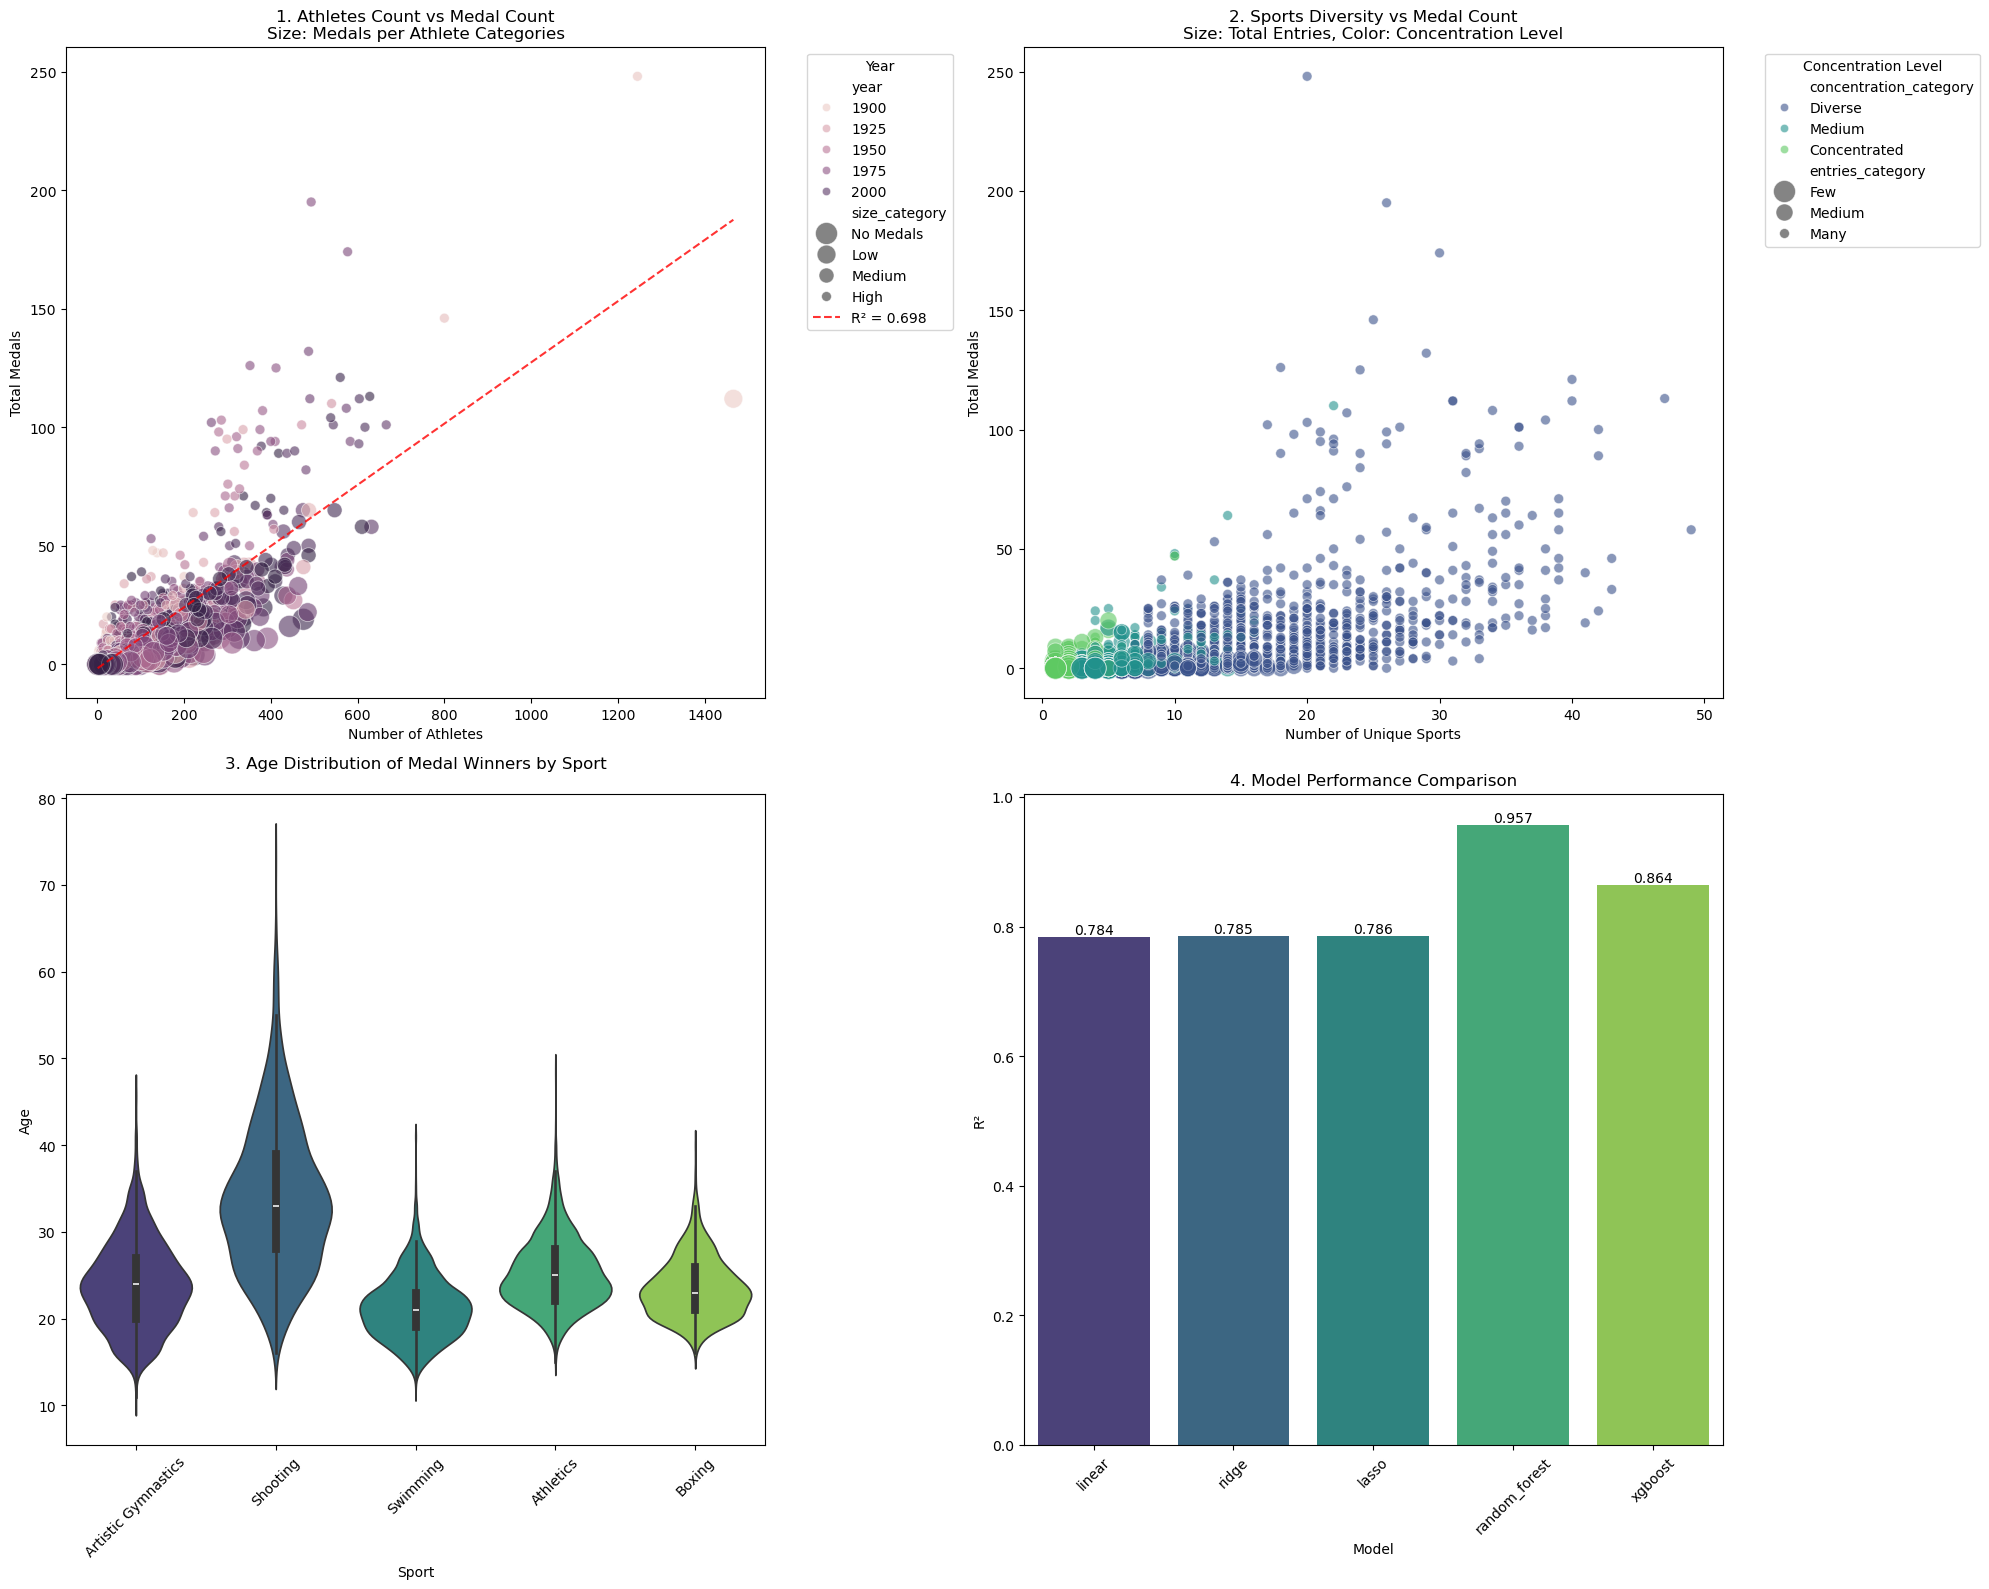

In [5]:
def create_key_visualizations(athletes_data, diversity_data, age_data, model_results):
    """Create four key visualizations"""
    print("Creating key visualizations...")
    
    fig = plt.figure(figsize=(20, 16))
    gs = GridSpec(2, 2, figure=fig)
    
    # 1. Athletes vs Medals Relationship
    ax1 = fig.add_subplot(gs[0, 0])
    medals_per_athlete = athletes_data['medals_per_athlete']
    non_zero_medals = medals_per_athlete[medals_per_athlete > 0]
    
    if len(non_zero_medals) > 0:
        bins = [
            0, 
            non_zero_medals.quantile(0.25),
            non_zero_medals.quantile(0.5),
            non_zero_medals.quantile(0.75),
            non_zero_medals.max()
        ]
        
        bins = sorted(list(set(bins)))
        
        athletes_data['size_category'] = pd.cut(
            medals_per_athlete,
            bins=bins,
            labels=['No Medals', 'Low', 'Medium', 'High'],
            include_lowest=True
        )
    else:
        athletes_data['size_category'] = 'No Medals'
    
    sns.scatterplot(
        data=athletes_data,
        x='athlete_count',
        y='total',
        alpha=0.6,
        hue='year',
        size='size_category',
        sizes=(50, 250),
        ax=ax1
    )
    
    # trend line
    z = np.polyfit(athletes_data['athlete_count'], athletes_data['total'], 1)
    p = np.poly1d(z)
    x_range = np.linspace(athletes_data['athlete_count'].min(), athletes_data['athlete_count'].max(), 100)
    r2 = r2_score(athletes_data['total'], p(athletes_data['athlete_count']))
    ax1.plot(x_range, p(x_range), "r--", alpha=0.8, label=f'R² = {r2:.3f}')
    
    ax1.set_title('1. Athletes Count vs Medal Count\nSize: Medals per Athlete Categories')
    ax1.set_xlabel('Number of Athletes')
    ax1.set_ylabel('Total Medals')
    ax1.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 2. Sports Diversity Impact
    ax2 = fig.add_subplot(gs[0, 1])
    
    entries = diversity_data['total_entries']
    entry_bins = [
        entries.min(),
        entries.quantile(0.33),
        entries.quantile(0.66),
        entries.max()
    ]
    entry_bins = sorted(list(set(entry_bins)))
    
    diversity_data['entries_category'] = pd.cut(
        entries,
        bins=entry_bins,
        labels=['Few', 'Medium', 'Many'],
        include_lowest=True
    )
   
    hhi = diversity_data['sports_concentration_hhi']
    hhi_bins = [
        hhi.min(),
        hhi.quantile(0.33),
        hhi.quantile(0.66),
        hhi.max()
    ]
    hhi_bins = sorted(list(set(hhi_bins)))
    
    diversity_data['concentration_category'] = pd.cut(
        hhi,
        bins=hhi_bins,
        labels=['Diverse', 'Medium', 'Concentrated'],
        include_lowest=True
    )
    
    sns.scatterplot(
        data=diversity_data,
        x='unique_sports',
        y='total',
        alpha=0.6,
        hue='concentration_category',
        size='entries_category',
        sizes=(50, 250),
        ax=ax2,
        palette='viridis'
    )
    
    ax2.set_title('2. Sports Diversity vs Medal Count\nSize: Total Entries, Color: Concentration Level')
    ax2.set_xlabel('Number of Unique Sports')
    ax2.set_ylabel('Total Medals')
    ax2.legend(title='Concentration Level', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    
   # 3. Age Distribution by Sport for Medal Winners
    ax3 = fig.add_subplot(gs[1, 0])
    
    selected_sports = ['Artistic Gymnastics', 'Shooting', 'Swimming', 'Athletics', 'Boxing']
    
    plot_data = []
    for sport in selected_sports:
        sport_data = age_data[
            (age_data['sport'] == sport) & 
            (age_data['medal'].notna())
        ]
        if not sport_data.empty:
            plot_data.append({
                'Sport': sport,
                'Ages': sport_data['age'].values,
                'Mean Age': sport_data['age'].mean(),
                'Std Age': sport_data['age'].std()
            })
    
    #  violin plot
    violin_parts = sns.violinplot(
        data=pd.DataFrame([
            {'Sport': d['Sport'], 'Age': age}
            for d in plot_data
            for age in d['Ages']
        ]),
        x='Sport',
        y='Age',
        ax=ax3,
        palette='viridis',
        inner='box'  # Shows quartile box inside violin
    )
    ax3.set_title('3. Age Distribution of Medal Winners by Sport\n')
    ax3.set_xlabel('Sport')
    ax3.set_ylabel('Age')
    ax3.tick_params(axis='x', rotation=45)
    

    
    # 4. Model Performance Comparison (Predictive)
    ax4 = fig.add_subplot(gs[1, 1])
    model_metrics = []
    for model_name, results in model_results.items():
        if model_name in ['linear', 'ridge', 'lasso', 'random_forest', 'xgboost']:
            model_metrics.append({
                'Model': model_name,
                'R²': results['r2'],
                'CV R²': results.get('cv_r2_mean', 0)
            })
    
    model_df = pd.DataFrame(model_metrics)
    sns.barplot(
        data=model_df,
        x='Model',
        y='R²',
        ax=ax4,
        palette='viridis'
    )
    ax4.set_title('4. Model Performance Comparison')
    ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45)
    
    for i, v in enumerate(model_df['R²']):
        ax4.text(i, v, f'{v:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    return fig
key_viz = create_key_visualizations(
    athletes_medals_features,
    sports_diversity_features,
    age_performance_features,
    athletes_medals_results
)

# save plots
key_viz.savefig(VIZ_PATH / 'key_findings.png', bbox_inches='tight', dpi=300)
print("Key visualizations completed and saved!")


## Key Findings from Visualizations

### 1. Athletes Count vs Medal Count
The scatter plot demonstrates that while sending more athletes generally leads to more medals (positive correlation), efficiency varies significantly. Some countries achieve high medal counts with relatively fewer athletes (shown by smaller circles), suggesting more strategic or focused Olympic programs.

### 2. Sports Diversity vs Medal Count
Countries participating in more unique sports tend to win more medals, but the relationship isn't just about quantity. The most successful countries (shown by smaller circles) typically maintain a balanced approach - participating in many sports while maintaining competitive strength (indicated by moderate concentration levels in the color scheme).

### 3. Age Distribution by Sport
Age patterns vary dramatically across sports, reflecting their different physical demands:
- Swimming and Artistic Gymnastics shows the youngest profile, with peak performance in teens/early 20s
- Shooting demonstrates that age is less limiting, with successful athletes well into their 40s
- Athletics, and Boxing cluster around mid-20s but with notable variations

### 4. Model Performance
Our predictive models show that Olympic success follows identifiable patterns, with the Random Forest model capturing the most complex relationships. This suggests that while medal outcomes are predictable to some extent, they depend on multiple interacting factors rather than simple linear relationships.
